<a href="https://colab.research.google.com/github/BrunoScaglione/Deep-Learning/blob/master/ConsidFINAL3(PSP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [0]:
#TensorFlow and Keras
#!pip install tensorflow==2.0.0
!pip install keras==2.3.0
from __future__ import absolute_import, division, print_function, unicode_literals
#!pip3 install --no-cache-dir -I tensorflow-gpu==1.14.0
import tensorflow as tf
from tensorflow import keras
#########################################tf.enable_eager_execution()
print(tf.__version__)
#!pip uninstall keras
#!pip install keras==2.3.0
#!pip install --upgrade setuptools --ignore-installed
print(keras.__version__)
#Helper libraries 
import IPython.display as display
import pathlib
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import time
import random 
from keras.preprocessing import image
import copy 
from keras.applications.resnet import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import BatchNormalization, AveragePooling2D, Conv2D, Conv3D, Activation, UpSampling2D, UpSampling3D, concatenate  
import IPython.display as display 
import io 
import cv2
import shutil
import os
import ntpath
#!pip install -U numpy
#!pip install chainercv
#import chainercv
import math
from random import shuffle
from tkinter import *
from PIL import Image, ImageTk 
import tkinter as Tk 



   ## nao ta importando BatchNormalization nao sei pq


2.0.0
2.2.4-tf


# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get original Image/Mask Paths

In [0]:
data_root_images, data_root_masks = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Training_dataset/Images'), pathlib.Path('/content/drive/My Drive/Colab Notebooks/Training_dataset/Masks/all')
#print(data_root_images, data_root_masks)
all_image_paths, all_masks_paths = list(sorted(data_root_images.glob('*'))), list(sorted(data_root_masks.glob('*')))
#print(all_image_paths, all_masks_paths)
all_image_paths, all_masks_paths  = [str(path) for path in all_image_paths], [str(path) for path in all_masks_paths]
#print(len(all_image_paths), len(all_masks_paths))
#print(all_image_paths[1639], all_masks_paths[1639])


#sorted(glob.glob('*.png'))


# Encode to TFRecrod format

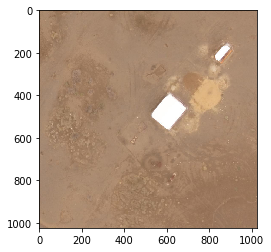

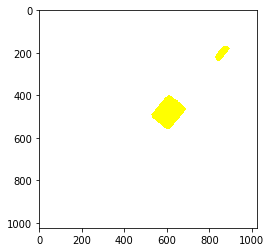

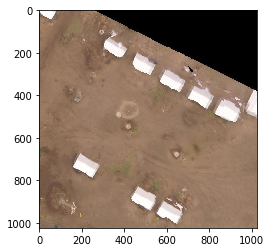

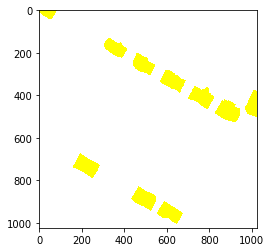

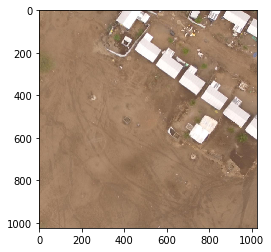

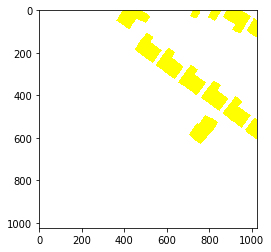

In [0]:
img_tensors, mask_tensors = np.array([]), np.array([])
img_list_str, mask_list_str = [], []

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.               im
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


for i in range(3):
  img_path, mask_path = all_image_paths[i], all_masks_paths[i]
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.show()
  mask = mpimg.imread(mask_path)
  plt.imshow(mask)
  plt.show()
  
  #img_raw, mask_raw = tf.io.read_file(img_path), tf.io.read_file(mask_path)
  #b = tf.image.decode_image(img_raw).get_shape()
  #print(b)
  #if i == 0:
    #a = tf.io.read_file(img_path)
    #b = tf.image.decode_image(a).get_shape()
    #print(b)
    #print(len(data))
  #from scipy.ndimage import imread
  #imgbytes = imread(img_path)
  #img_str = imgbytes.tostring()
  #print(len(img_str))         ## metodo alterna
  image_string, mask_string = open(img_path, 'rb').read(), open(mask_path, 'rb').read()  
  
  with open(img_path, 'rb') as f:
    im4 = f.read()
  #print(im4)
  with open(mask_path, 'rb') as g:
    im5 = g.read()
  #if i <2:
   # print(image_string)
    #print(len(image_string))       ## len ta dando diferente do numero de pixels da imagem, nao faco ideias pq
    #for l in image_string:
      #print(l, end=" ")
  #image_string, mask_string = tf.decode_raw(img_raw), tf.decode_raw(mask_raw)
  #print(len(image_string))
  img_list_str.append(im4)
  mask_list_str.append(im5)
  #img_tensor, mask_tensor = tf.image.decode_image(img_raw), tf.image.decode_image(mask_raw)
  #img_tensors = np.append(img_tensors, img_tensor)
  #mask_tesnors = np.append(mask_tensors, mask_tensor)
  
  

# Create a dictionary with features that may be relevant.
def image_example(image_string, mask_string):
  #image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'image_raw': _bytes_feature(image_string),
      'mask_raw': _bytes_feature(mask_string)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))


it = 0
#print(list(zip(img_list_str, mask_list_str))[0][1])
#print(list(zip(img_list_str, mask_list_str))[1][1])
for img, msk in list(zip(img_list_str, mask_list_str)):
  
  record_file = 'images.tfrecords{}'.format(it)
  with tf.io.TFRecordWriter(record_file) as writer:
    tf_example = image_example(img, msk)

    #print(tf_example)
    #print(len(tf_example.SerializeToString()))
    writer.write(tf_example.SerializeToString())
    it += 1
  

# Decode to numpy matrixes

In [0]:
image_feature_description = { 'image_raw': tf.io.FixedLenFeature([], tf.string), 'mask_raw': tf.io.FixedLenFeature([], tf.string)}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

restored_images, restored_masks = [], []                           #   np.append nao funciiona !! pq ele vai cocantanar uma coisa na dimensao da sua lista, que eh nula entao da merda
it2 = 0
for w in range(3):
    example = tf.data.TFRecordDataset(filenames = ['/content/images.tfrecords{}'.format(it2)])
    parsed_image_dataset = example.map(_parse_image_function)
    #image = tf.decode_raw(parsed_image_dataset['image_raw'], tf.uint8)
    ##reader = tf.TFRecordReader()
    ##serialized_example = reader.read('/content/images.tfrecords{}'.format(w))
    ##parsed_image_dataset = example.map(_parse_image_function)
    ##image = tf.decode_raw(parsed_image_dataset['image_raw'], tf.uint8)
    #print(image)
    #print (parsed_image_dataset)                                                                             
    for image_features in parsed_image_dataset:
        #print(image_features['image_raw'])
        #splitted = tf.sparse.split(sp_input=image_features['image_raw'], num_split = 3), 
        #print(image_features['image_raw'].values.numpy())
        #print(image_features['image_raw'].values)
        #image_raw = tf.decode_raw(image_features['image_raw'].numpy(), tf.uint8)           ###### decode raw ruim
        image_raw_4 = Image.open(io.BytesIO(image_features['image_raw'].numpy()))
        #print(image_raw_4)
        #one = image_raw[0]
        #print(len(one))
        #print(image_raw.get_shape())
        image_reshaped = np.reshape(image_raw_4, [1024, 1024, 3])
        #mask_raw = tf.decode_raw(image_features['mask_raw'].numpy(), tf.uint8)
        mask_raw_4 = Image.open(io.BytesIO(image_features['mask_raw'].numpy()))
        #print(np.array(mask_raw_4).shape)
        mask_reshaped = np.reshape(mask_raw_4, [1024, 1024, 4])
        '''if it2 == 16:
          for i in range(200):
            choice = random.choice(mask_reshaped)
            print(random.choice(choice))'''
        im = Image.fromarray(mask_reshaped)
        rgb_mask = im.convert('RGB')
        mask_reshaped = np.asarray(rgb_mask)
        #plt.imshow(mask_reshaped)
        #plt.show()
        #plt.imshow(image_reshaped)
        #plt.show()
        #if it2 == 0:
          #for line in mask_reshaped:
            #for rgba in line:
              #print(rgba)
        if np.amax(mask_reshaped) != 0:
          #image_reshaped = tf.image.convert_image_dtype(image_reshaped, tf.float32)
          #mask_reshaped = tf.image.convert_image_dtype(mask_reshaped, tf.float32)
          restored_images.append(image_reshaped)
          restored_masks.append(mask_reshaped)
    it2+= 1
        
#print(restored_images)



#print(restored_images)

'''
#print(restored_images)
tf.decode_raw(image_features['image_raw'], tf.uint8)
    np.append(image_raw, image_features['image_raw'].values.numpy())
    print(image_raw)
    np.append(mask_raw, image_features['mask_raw'].values.numpy()) 
    


#print(parsed_image_dataset)                                                                ### ta dando problema aqui tb n sei pq
image_raw = tf.image.decode_image(image_raw)
mask_raw = tf.image.decode_image(mask_raw)   ''' 

"\n#print(restored_images)\ntf.decode_raw(image_features['image_raw'], tf.uint8)\n    np.append(image_raw, image_features['image_raw'].values.numpy())\n    print(image_raw)\n    np.append(mask_raw, image_features['mask_raw'].values.numpy()) \n    \n\n\n#print(parsed_image_dataset)                                                                ### ta dando problema aqui tb n sei pq\nimage_raw = tf.image.decode_image(image_raw)\nmask_raw = tf.image.decode_image(mask_raw)   "

# Criate Dataset and Apply Augmentations


0
3


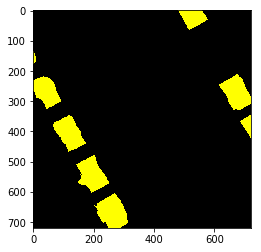

In [0]:
'''a_root_images, data_root_masks = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Training_dataset/Resized_images_70%'), pathlib.Path('/content/drive/My Drive/Colab Notebooks/Training_dataset/Resized_Masks_70%')
#print(data_root_images, data_root_masks)
all_image_paths, all_masks_paths = list(data_root_images.glob('*')), list(data_root_masks.glob('*'))
#print(all_image_paths, all_masks_paths)
all_image_paths, all_masks_paths  = [str(path) for path in all_image_paths], [str(path) for path in all_image_paths]
#print(len(all_image_paths), len(all_masks_paths))
#print(all_image_paths[1639], all_masks_paths[1639])


img_tensors, mask_tensors = np.array([]), np.array([])
for i in range(len(all_image_paths)):
  img_path, mask_path = all_image_paths[i], all_masks_paths[i]
  img_raw, mask_raw = tf.io.read_file(img_path), tf.io.read_file(mask_path)
  img_tensor, mask_tensor = tf.image.decode_image(img_raw), tf.image.decode_image(mask_raw)
  img_tensors = np.append(img_tensors, img_tensor)
  mask_tesnors = np.append(mask_tensors, mask_tensor)  '''


print(0)
seed = 4
#np.random.shuffle(img_tensors, seed = seed)             
#np.random.shuffle(mask_tensors, seed = seed)

#restored_images = np.array(restored_images)

#restored_masks = np.array(restored_masks)
num_images = len(restored_images)
print(num_images)
#print(type(restored_images[0]))
num_division = math.floor(0.7*num_images)

#img_train_ds = tf.data.Dataset.from_tensor_slices(restored_images[0:num_division])
img_train_ds = restored_images[0:num_division]
#print(1)
#mask_train_ds = tf.data.Dataset.from_tensor_slices(restored_masks[0:num_division])
mask_train_ds = restored_masks[0:num_division]
#print(2)
#img_val_ds = tf.data.Dataset.from_tensor_slices(restored_images[(num_division):num_images])
img_val_ds = restored_images[(num_division):num_images]
#print(3)
#mask_train_ds tf.data.Dataset.from_tensor_slices((mask_tensors[1174:1670]).astype(np.float32))
#mask_val_ds = tf.data.Dataset.from_tensor_slices(restored_masks[(num_division):num_images])
mask_val_ds = restored_masks[(num_division):num_images]
#print(4)

def random_rotate(x, y):
  # Rotate 0, 90, 180, 270 degrees
  x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, seed = seed, dtype=tf.int32))
  y = tf.image.rot90(y, tf.random.uniform(shape=[], minval=0, maxval=4, seed = seed, dtype=tf.int32))
  
  return x.numpy(), y.numpy()



def random_flip(x, y):
  
  x = tf.image.random_flip_left_right(x, seed = seed)
  x = tf.image.random_flip_up_down(x, seed = seed)

  y = tf.image.random_flip_left_right(y, seed = seed)
  y = tf.image.random_flip_up_down(y, seed = seed)
  
  
  return x.numpy(), y.numpy()

'''
def image_mirroring(img, label):   ## do pspnet msm coisa da de cima, mas deve ser bem melhor
  distort_left_right_random = tf.random_uniform([1], 0, 1.0, dtype=tf.float32)[0]
  mirror = tf.less(tf.stack([1.0, distort_left_right_random, 1.0]), 0.5)
  mirror = tf.boolean_mask([0, 1, 2], mirror)
  img = tf.reverse(img, mirror)
  label = tf.reverse(label, mirror)
  
  return img, labe            '''

cropsize = 720
def random_crop(x, y):
  cropped_image = tf.image.random_crop(x, [cropsize, cropsize, 3], seed = seed)
  cropped_mask  = tf.image.random_crop(y, [cropsize, cropsize, 3], seed = seed) 
  

  # fiz 70% arbitrariamente

  return cropped_image.numpy(), cropped_mask.numpy()

'''def random_crop_and_pad_image_and_labels(image, label, crop_h, crop_w, ignore_label=255): ## da psp net,quase msm coisa da de cima, mas deve ser bem melhor
  label = tf.cast(label, dtype=tf.float32)
  label = label - ignore_label # Needs to be subtracted and later added due to 0 padding.
  combined = tf.concat(axis=2, values=[image, label])
  image_shape = tf.shape(image)
  combined_pad = tf.image.pad_to_bounding_box(combined, 0, 0, tf.maximum(crop_h, image_shape[0]), tf.maximum(crop_w, image_shape[1]))

  last_image_dim = tf.shape(image)[-1]
  last_label_dim = tf.shape(label)[-1]
  combined_crop = tf.random_crop(combined_pad, [crop_h,crop_w,4])
  img_crop = combined_crop[:, :, :last_image_dim]
  label_crop = combined_crop[:, :, last_image_dim:]
  label_crop = label_crop + ignore_label
  label_crop = tf.cast(label_crop, dtype=tf.uint8)

  # Set static shape so that tensorflow knows shape at compile time.
  img_crop.set_shape((crop_h, crop_w, 3))
  label_crop.set_shape((crop_h,crop_w, 1))
  return img_crop, label_crop                    '''




#np.random.seed(4)

def random_resize(x, y):
  a =  np.random.randint(0.5, 2)
  (h, w, c) = x.shape
  print(h, w)
  image_x = Image.fromarray(x)
  image_y = Image.fromarray(y)
  image_x_resized = image_x.resize((100, 100))         ####### TA BUGADO SOH CONSIGO FAZER COM VALOR FIZO DE WIDHT E HEIGHT!!
  image_y_resized = image_y.resize((100, 100))
  img_x = np.asarray(image_x_resized)
  mask_y = np.asarray(image_y_resized)
  
  
  #listt =  [x, y]
  #print(x.shape)  
  #q = tf.convert_to_tensor(listt)
  ######o tensor ta virando um numpy ndarray por alguma razao
  #resized_images = tf.keras.backend.resize_images(q, new_size, new_size, "channels_last")
  #print(resized_images.get_shape())
  #x = list_img_mask_resized = tf.keras.backend.resize_images(list_img_mask, a, b, 'channels_last')
  #y = tf.keras.backend.resize_images(y, c, d, 'channels_last')
  #x, y = list_img_mask[0], list_img_mask[1]

  return img_x, mask_y

'''def image_scaling(img, label): ## do pspnet msm coisa da de cima mas deve ser bem melhor
  scale = tf.random.uniform([1], minval=0.5, maxval=2.0, dtype=tf.float32, seed=None)
  h_new = tf.dtypes.cast(tf.multiply(tf.dtypes.cast((tf.shape(img)[0]), dtype=tf.float32), scale), dtype=tf.int32)                  ########h_new = tf.to_int32(tf.multiply(tf.to_float(tf.shape(img)[0]), scale))
  w_new = tf.dtypes.cast(tf.multiply(tf.dtypes.cast((tf.shape(img)[1]), dtype=tf.float32), scale), dtype=tf.int32)             ########## w_new = tf.to_int32(tf.multiply(tf.to_float(tf.shape(img)[1]), scale))
  new_shape = tf.squeeze(tf.stack([h_new, w_new]), axis=1)
  img = tf.image.resize_images(img, new_shape)
  label = tf.image.resize_nearest_neighbor(tf.expand_dims(label, 0), new_shape)
  label = tf.squeeze(label)
                                                                                                 
  img = tf.clip_by_value(img, 0.0, 1.0)
  label = tf.clip_by_value(label, 0.0, 1.0)
  
  #tf.dtypes.cast((tf.shape(img)[0]), scale), dtype=tf.float32)
  

  return img.numpy(), label.numpy() '''


def Gaussian_noise(x, y):
  #height, width = x.get_shape()[0:2]
 
  gn = tf.random.normal((cropsize, cropsize, 3), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
  
  
  x_gn = tf.math.add(x,gn)
  y_gn = tf.math.add(y,gn)
  
  x_gn = tf.clip_by_value(x_gn, 0.0, 1.0)
  y_gn = tf.clip_by_value(y_gn, 0.0, 1.0)
  
  
  
  return x_gn.numpy(), y_gn.numpy()

#print(5)
#img_mask_train_ds = tf.data.Dataset.zip((img_train_ds, mask_train_ds))
img_mask_train_ds = list(zip(img_train_ds, mask_train_ds))
#print(type(img_train_ds[0][0]))

#print(6)
#img_mask_val_ds = tf.data.Dataset.zip((img_val_ds, mask_val_ds))
img_mask_val_ds = list(zip(img_val_ds, mask_val_ds))
#print(7)
augmentations = [random_flip, random_rotate, random_crop]   # RESIZE IMAGES TA DANDO ERRADO!!!!!!!!!!!!
#augmentations = [random_flip]                                                                                                               ### talvez mudar pra por as funcoes  em ''' ''' do pspnet
#print(8)
          
#print(img_mask_train_ds[0][1])
  
  ### essa útima parte é pra ficar entre [-1 1]  
  
  
def apply_aug(img_mask_train_ds):
  # Add the augmentations to the dataset
  
  for aug in augmentations:
      # Apply the augmentation, run 4 jobs in parallel.
    #img_mask_train_ds = img_mask_train_ds.map(aug, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    img_mask_train_ds = [aug(img,mask) for (img,mask) in img_mask_train_ds]
    shuffle(img_mask_train_ds)
  return img_mask_train_ds

img_mask_train_ds = apply_aug(img_mask_train_ds) 
#msk = Image.fromarray(img_mask_train_ds[0][1])
#msk.show()
'''
img_mask_train_ds_stacked =[]
for i in range(70):
  img_mask_train_ds_stacked = img_mask_train_ds_stacked + apply_aug(img_mask_train_ds)
  '''
  

plt.imshow(img_mask_train_ds[0][1])
plt.show()


#for i in range(200):
  #choice = random.choice(img_mask_train_ds[0][1])
  #print(random.choice(choice))
  
#print(len(img_mask_train_ds))
#print(img_mask_train_ds[1])
#print(img_mask_train_ds)       #AQUI EU TIREI PRA VER SOH RODANDO
  #return img_mask_train_ds

#img_mask_train_ds_aug = apply_aug(image_mask_train_ds)
#print(type(img_mask_train_ds))
#mean_x, mean_y = tf.reduce_mean(img_mask_train_ds, 1)
#mean_y = tf.reduce_mean(mask_train_ds, 1)

#max_value = tf.math.reduce_max(img_mask_train_ds)         
#def change_range(x,y):   
  #x_converted = tf.image.convert_image_dtype(x, tf.float32)
  #y_converted = tf.image.convert_image_dtype(x, tf.float32)
  #x, y = (x - mean_x)/max_value, (y- mean_y/max_value)
  #return  2*x-1, 2*y-1 
  
  

def convert_to_mask(mask):
  h, w, l = mask.shape
  mask_new = np.zeros((h, w))
  for line in range(len(mask)):
    for rgba in range(len(mask[0])):
      element = mask[line][rgba]
      #print(element)
      if np.array_equal(element, [0,0,0]):  
        mask_new[line][rgba] = 0
      elif np.array_equal(element, [255,255,0]):
        mask_new[line][rgba] = 1
      elif np.array_equal(element, [255,0,255]):
        mask_new[line][rgba] = 2
      else:
        mask_new[line][rgba] = 3

  return mask_new
   
def small_range(img):
  img_small_range = tf.image.convert_image_dtype(img, tf.float32)
  return img_small_range

        
        
        #### branco ->[0 0 0 0]  -> background -> 0
        #### amarelo -> [255 255 0 255] -> casa -> 1
        #### roxo -> [255 0 255 255] -> rua -> 2
        #### vrmleho -> [255 0 0 255] -> rio -> 3
      

img_mask_train_ds = [(small_range(img),convert_to_mask(mask)) for (img,mask) in img_mask_train_ds]
img_mask_val_ds = [(small_range(img),convert_to_mask(mask)) for (img,mask) in img_mask_val_ds]

'''for i in range(200):
  choice = random.choice(img_mask_train_ds[0][1])
  print(random.choice(choice)) '''

#print(len(img_mask_train_ds))
#print(img_mask_train_ds[0][1].shape)
#print(img_mask_train_ds[0][1])


#img_mask_train_ds = img_mask_train_ds.map(change_range)
#img_mask_val_ds = img_mask_val_ds.map(change_range)
#img_mask_val_ds = img_mask_val_ds.shuffle(buffer_size = num_images)
shuffle(img_mask_val_ds)

#img_mask_train_ds = img_mask_train_ds.shuffle(buffer_size = num_images)
shuffle(img_mask_train_ds)
#print(img_mask_train_ds)
#img_mask_train_ds = img_mask_train_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size= 1670))
#img_mask_train_ds = img_mask_train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# Model

In [0]:
#!pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps
#from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()

from keras.optimizers import Adam 

'''if os.path.exists("/content/drive/My Drive/Colab Notebooks/Last Model(PSP)/model_psp.hdf5"):
  
  model_psp = load_model('/content/drive/My Drive/Colab Notebooks/Last Model(PSP)/model_psp.hdf5')
  
else:'''
base_model_X =  ResNet50(weights='imagenet', include_top=False)

for layer in base_model_X.layers:
  layer.trainable = False




psp_input = base_model_X.output              #layers[-1]
#shape_input = psp_input.shape
#print(shape_input)
#shape = tf.shape(psp_input)[1:3]       

a = AveragePooling2D(pool_size = 120)(psp_input)
a = Conv2D(filters=512, kernel_size = 1, use_bias = False, padding ='same')(a)              
a = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.00001)(a) 
a = Activation('relu')(a)        
a = UpSampling2D(size = (120, 120), interpolation='bilinear')(a)            ####dado problema de upsampling output dimensions must be positive ??


b = AveragePooling2D(pool_size = 240)(psp_input)
b = Conv2D(512, 1, use_bias = False, padding ='same')(b)               
b = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.00001)(b)
b = Activation('relu')(b)      
b = UpSampling2D(size = (240, 240), interpolation='bilinear')(b)


c = AveragePooling2D(pool_size = 360)(psp_input)
c = Conv2D(512, 1, use_bias = False, padding= 'same')(c)                       
c = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.00001)(c)
c = Activation('relu')(c)      
c = UpSampling2D(size = (360, 360), interpolation='bilinear')(c)

d = AveragePooling2D(pool_size = 720)(psp_input)
d = Conv2D(512, 1, use_bias = False, padding='same')(d)                         
d = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.00001)(d)
d = Activation('relu')(d)      
d = UpSampling2D(size = (720,720), interpolation='bilinear')(d)


e = concatenate([psp_input, a, b, c, d])
e = Conv2D(512, 1, use_bias = False, padding='same')(e)    
e = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.00001)(e)
e = Activation('relu')(e)
e = UpSampling2D(size = (32,32), interpolation='bilinear')(e)      #####nao sei ppq nao fala dessa parte no paper, n tenho crtz se eh 8 tb 
soft_output_psp = Conv2D(4, 1, use_bias = True, activation ='softmax', padding='same') (e) 
#soft_output_psp = Activation('softmax')(raw_output_psp)

'''
Predictions: ignoring all predictions with labels greater or equal than n_classes
raw_prediction = tf.reshape(raw_output, [-1, args.num_classes])
label_proc = prepare_label(label_batch, tf.stack(raw_output.get_shape()[1:3]), num_classes=args.num_classes, one_hot=False) # [batch_size, h, w]
raw_gt = tf.reshape(label_proc, [-1,])
indices = tf.squeeze(tf.where(tf.less_equal(raw_gt, args.num_classes - 1)), 1)
gt = tf.cast(tf.gather(raw_gt, indices), tf.int32)                                      ## ISSO TA NO CODIGO DA PSPNET MAS NAO ENTENDI SAMERDA KKKKK                                     
prediction = tf.gather(raw_prediction, indices) '''

model_psp = Model(inputs= base_model_X.input , outputs= soft_output_psp)

EPOCHS_PSP  = 2
BATCH_SIZE_PSP = 32
#INPUT_SIZE = '713,713'  # no pspnet 
MOMENTUM = 0.9        # adam eh msm coisa
POWER = 0.9   # leraningrate persolanizada               
WEIGHT_DECAY = 0.0001 # learning rate personalizada
INITIAL_LEARNING_RATE = 0.01 #learning rate personlaizada 
  
def schedule(epoch):
  INITIAL_LEARNING_RATE = 0.01
  EPOCHS_PSP  = 2
  POWER = 0.9
  LEARNING_RATE = INITIAL_LEARNING_RATE*(1- (epoch/EPOCHS_PSP))**POWER 
  return LEARNING_RATE 
  
#my_adam = Adam(lr = poly_learning, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_psp.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])  #            IoU dando problema!!!!!!!!!!!!!!!!!!!!!!!!




checkpoint_path = '/content/drive/My Drive/Colab Notebooks/Last Model(PSP)/model_psp.hdf5'              #best_model-{epoch:02d}-{val_loss:.2f} da pra usar isso mas fica dificil laodar ai
checkpoint_dir = os.path.dirname(checkpoint_path)
 # da pra colocar period = 2 se ficar mt pesado
#model_psp.save_weights(checkpoint_path.format(epoch=0))


psp_callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),         #### comecar com patience alto ou sem early stopping
ModelCheckpoint(filepath = checkpoint_path, verbose = 1, save_best_only=True), LearningRateScheduler(schedule, verbose=0)]

#order = np.argsort(np.random.random(img_mask_train_ds.shape))                  
#print(order)


#train_data = train_data[order]
#train_labels = train_labels[order]


#get_iterator = img_mask_train_ds.make_one_shot_iterator()
#get_batch = get_iterator.get_next()



img_train_ds, mask_train_ds = zip(*img_mask_train_ds)
img_train_ds = list(img_train_ds)
mask_train_ds = list(mask_train_ds)
mask_train_ds = np.expand_dims(mask_train_ds, -1)
#print(img_train_ds)
img_val_ds, mask_val_ds = zip(*img_mask_val_ds)
img_val_ds = list(img_val_ds)
mask_val_ds = list(mask_val_ds)
mask_val_ds = np.expand_dims(mask_val_ds, -1)

print(mask_train_ds[0].shape)
print(len(mask_train_ds))
#print(img_trai_ds.shape)


model_psp.summary()

print('started fit')

model_psp_history = model_psp.fit(x=np.array(img_train_ds), y=np.array(mask_train_ds), batch_size= 2, epochs=EPOCHS_PSP, verbose=1, callbacks= psp_callbacks, validation_data= (np.array(img_val_ds), np.array(mask_val_ds)))          #

#model_psp.save('/content/drive/My Drive/Colab Notebooks/Last Model(PSP)/model_psp.h5')


loss = model_psp_history.history['loss']
val_loss = model_psp_history.history['val_loss']
val_accuracy = model_psp_history.history[IoU]   

epochs = range(EPOCHS)                  
plt.figure()
#plt.plot(epochs, accuracy, 'r', label='Training IoU')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g-', label='Validation loss')
plt.plot(epochs, val_accuracy, 'ro' , label='Validation IoU')
plt.title('Training and Validation IoU and loss')
plt.xlabel('Epoch')
plt.ylabel('IoU Value') 
plt.legend()
plt.show() 

'''

import Image

image = Image.open('File.jpg')
image.show() '''

(720, 720, 1)
2
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________

InvalidArgumentError: ignored

In [0]:
!pip install -q git+https://github.com/tensorflow/examples.git
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

train = dataset['train']

print(train)
print(train.get_shape())

# Test Memory

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
a= [[[1,2,3], [4,5,6]],[[7,8,9],[10,11,12]]]


#a[a==1] = 2  
print(l)    

np.where()
  



In [0]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip install --upgrade " + ' '.join(packages), shell=True)

1